In [2]:
import numpy as np
import pandas as pd
import nltk
import matplotlib.pyplot as plt
import string
from sklearn.decomposition import PCA
import warnings
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix , classification_report
from sklearn.preprocessing import LabelEncoder
import re
from collections import Counter
warnings.filterwarnings('ignore')

In [3]:
#This function swaps 2 columns inside the dataframe
def swap_columns(df, col1, col2):
    col_list = list(df.columns)
    x, y = col_list.index(col1), col_list.index(col2)
    col_list[y], col_list[x] = col_list[x], col_list[y]
    df = df[col_list]
    return df

In [4]:
#This function removes punctuation from string
def remove_punctuations(text):
    for punctuation in string.punctuation:
        text = text.replace(punctuation, '')
    return text

In [5]:
#Reading dataset
Email_dataset = pd.read_csv("spam_ham_dataset.csv")

In [6]:
# #Show dataset
# Email_dataset.head()

In [7]:
s=Email_dataset["label"].value_counts()
s

label
ham     3672
spam    1499
Name: count, dtype: int64

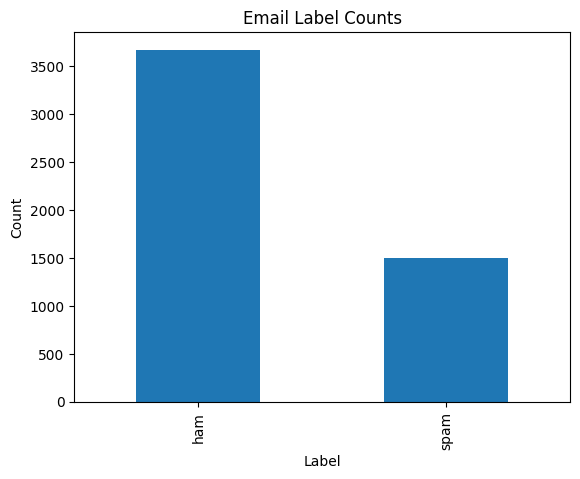

In [8]:
# create a bar chart
s.plot.bar()

# set the title and axis labels
plt.title("Email Label Counts")
plt.xlabel("Label")
plt.ylabel("Count")

# display the chart
plt.show()

In [9]:
#Dropping columns that are not needed
Email_dataset = Email_dataset.drop('Unnamed: 0', axis=1)
Email_dataset = Email_dataset.drop('label', axis=1)

In [10]:
Email_dataset.head()

,text,label_num
0,Subject: enron methanol ; meter # : 988291\r\n...,0
1,"Subject: hpl nom for january 9 , 2001\r\n( see...",0
2,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0
3,"Subject: photoshop , windows , office . cheap ...",1
4,Subject: re : indian springs\r\nthis deal is t...,0


In [11]:
#Creating a new feature, extracting subject of each email
subjects = []
for i in range(len(Email_dataset)):
    ln = Email_dataset["text"][i]
    line = ""
    for i in ln:
        if(i == '\r'):
            break
        line = line + i
    line = line.replace("Subject" , "")
    subjects.append(line)

In [12]:
Email_dataset['Subject'] = subjects

In [13]:
#Renaming the dataframe columns
Email_dataset.columns = ["Email_text" , "Labels" , "Email_Subject"]

In [14]:
#Swapping the dataframe columns 
Email_dataset = swap_columns(Email_dataset, 'Labels', 'Email_Subject')

In [15]:
#Creting seprate dataset for Spam and Non Spam emails, to perform analysis 
Spam = pd.DataFrame(columns = ['Email_text', 'Email_Subject', 'Labels'])
Non_Spam = pd.DataFrame(columns = ['Email_text', 'Email_Subject', 'Labels'])

In [16]:
#Creating Non_Spam email dataset 
for i in range(len(Email_dataset)):
    if(Email_dataset['Labels'][i] == 0):
        new_row = {'Email_text':Email_dataset['Email_text'][i], 'Email_Subject':Email_dataset['Email_Subject'][i], 'Labels':Email_dataset['Labels'][i]}
        Non_Spam.loc[len(Non_Spam)] = new_row

In [17]:
#Creating Spam email dataset 
for i in range(len(Email_dataset)):
    if(Email_dataset['Labels'][i] == 1):
        new_row = {'Email_text':Email_dataset['Email_text'][i], 'Email_Subject':Email_dataset['Email_Subject'][i], 'Labels':Email_dataset['Labels'][i]}
#         Spam = Spam.append(new_row, ignore_index=True)
        Spam.loc[len(Spam)] = new_row

In [18]:
Email_dataset.head()

,Email_text,Email_Subject,Labels
0,Subject: enron methanol ; meter # : 988291\r\n...,: enron methanol ; meter # : 988291,0
1,"Subject: hpl nom for january 9 , 2001\r\n( see...",": hpl nom for january 9 , 2001",0
2,"Subject: neon retreat\r\nho ho ho , we ' re ar...",: neon retreat,0
3,"Subject: photoshop , windows , office . cheap ...",": photoshop , windows , office . cheap . main ...",1
4,Subject: re : indian springs\r\nthis deal is t...,: re : indian springs,0


In [19]:
#Converting all strings to lowercase
Email_dataset['Email_Subject'] = Email_dataset['Email_Subject'].str.lower()
Email_dataset['Email_text'] = Email_dataset['Email_text'].str.lower()

In [20]:
#Removing Punctuation from the data
Email_dataset['Email_Subject'] = Email_dataset['Email_Subject'].apply(remove_punctuations)
Email_dataset['Email_text'] = Email_dataset['Email_text'].apply(remove_punctuations)

Convert the 'Email_text' column to a matrix of token counts.

In [21]:
X = Email_dataset['Email_text']
y = Email_dataset['Labels'].values

In [22]:
# print(X)
# print(y)


In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [24]:
# print(X_train[:5])
# print([type(x) for x in X_train[:5]])


### vectorizer

In [25]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Create separate instances for train and test data
vectorizer = TfidfVectorizer(min_df=1, stop_words="english", lowercase=True)


X_train_features = vectorizer.fit_transform(X_train)
X_test_features = vectorizer.transform(X_test) # Use transform, not fit_transform

y_train = y_train.astype('int')
y_test = y_test.astype('int')


### dump the vectorizer

In [26]:
import pickle

with open('vectorizer.pkl', 'wb') as file:
    pickle.dump(vectorizer, file)

In [27]:
from sklearn.linear_model import LogisticRegression
Logistic_model = LogisticRegression(random_state = 0)
Logistic_model.fit(X_train_features, y_train)

LogisticRegression(random_state=0)

### Checking accuaracy on training set

In [28]:
y_pred = Logistic_model.predict(X_train_features)
cm = confusion_matrix(y_train, y_pred)
print(cm)
accuracy_score(y_train, y_pred)

[[2914   16]
 [   0 1206]]


0.9961315280464217

### Confusiong matrix for training set

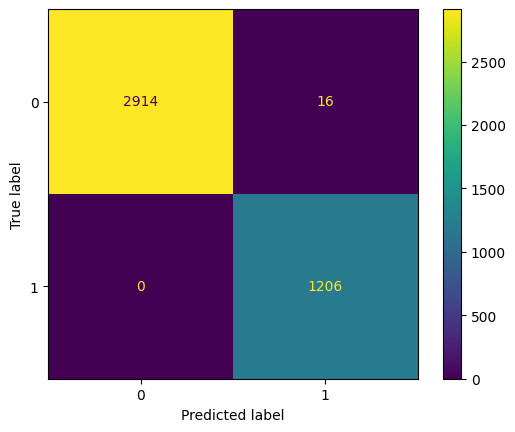

In [29]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Compute confusion matrix
cm = confusion_matrix(y_train, y_pred)

# Create a ConfusionMatrixDisplay instance
cmd = ConfusionMatrixDisplay(cm, display_labels=Logistic_model.classes_)

# Plot the confusion matrix
cmd.plot()


### Checking Accuracy on testing set 

In [30]:
y_pred = Logistic_model.predict(X_test_features)
cm = confusion_matrix(y_test, y_pred)
print(cm)
accuracy_score(y_test, y_pred)

[[735   7]
 [  4 289]]


0.9893719806763285

### Confusion Matrix for test set

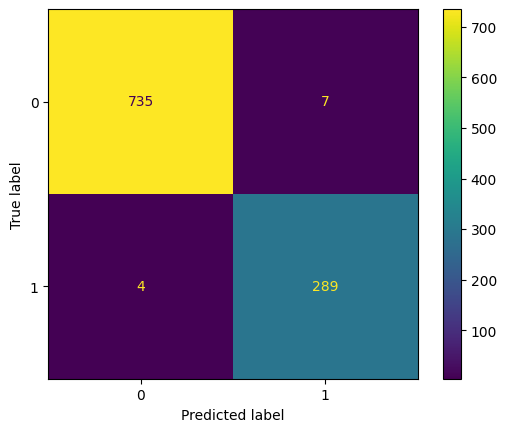

In [31]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Create a ConfusionMatrixDisplay instance
cmd = ConfusionMatrixDisplay(cm, display_labels=Logistic_model.classes_)

# Plot the confusion matrix
cmd.plot()


In [32]:
import math
from sklearn.metrics import r2_score, mean_squared_error,mean_absolute_percentage_error

maxY=max(y_test)
minY=min(y_test)
a=maxY-minY
print ("The R-Squared value is: "+str(r2_score(y_test, y_pred)))
print ("The Mean Squared Error value is: "+str(mean_squared_error(y_test, y_pred)))
print ("The Root Mean Squared Error value is: "+str(math.sqrt(mean_squared_error(y_test, y_pred))))
print ("The Normalize Root Mean Squared Error value is: "+str(math.sqrt(mean_squared_error(y_test, y_pred))/a*100))
print ("The Mean Absolute Error value is: "+str(mean_absolute_percentage_error(y_test, y_pred)*100))

The R-Squared value is: 0.9476325400402933
The Mean Squared Error value is: 0.010628019323671498
The Root Mean Squared Error value is: 0.1030922854711811
The Normalize Root Mean Squared Error value is: 10.30922854711811
The Mean Absolute Error value is: 3045912791458306.5


### Dumpt the model to a external file

In [33]:
import pickle

with open('logistic_model.pkl', 'wb') as file:
    pickle.dump(Logistic_model, file)

### Prediction

In [34]:
from sklearn import feature_extraction

input_text = ["hello world"]  
input_text_features = vectorizer.transform(input_text)
prediction = Logistic_model.predict(input_text_features)


if (prediction[0]==1):
    print("Normal Mail")
else:
    print("Spam Mail")

Normal Mail


# decision_tree_classification

In [35]:
from sklearn.tree import DecisionTreeClassifier
decision_tree_model = DecisionTreeClassifier(random_state = 0)
decision_tree_model.fit(X_train_features, y_train)

DecisionTreeClassifier(random_state=0)

In [36]:
# y_pred = classifier.predict(X_test)
# print(np.concatenate((y_pred.reshape(len(y_pred),1), y_test.reshape(len(y_test),1)),1))

### Checking accuaracy on training set

In [45]:
y_pred = decision_tree_model.predict(X_train_features)
cm = confusion_matrix(y_train, y_pred)
print(cm)
print(accuracy_score(y_train, y_pred))

[[2930    0]
 [   0 1206]]
1.0


### Confusiong matrix for training set

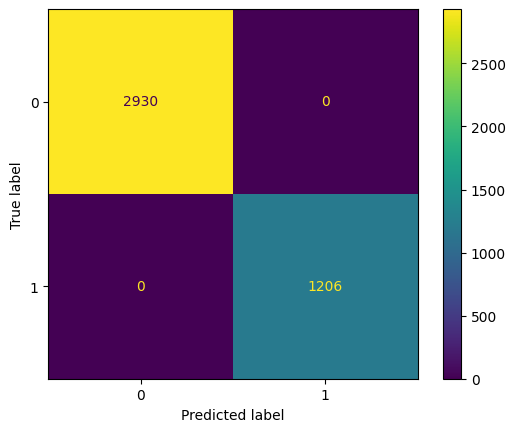

In [38]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Compute confusion matrix
cm = confusion_matrix(y_train, y_pred)

# Create a ConfusionMatrixDisplay instance
cmd = ConfusionMatrixDisplay(cm, display_labels=decision_tree_model.classes_)

# Plot the confusion matrix
cmd.plot()


### Checking Accuracy on testing set 

In [39]:
y_pred = Logistic_model.predict(X_test_features)
cm = confusion_matrix(y_test, y_pred)
print(cm)
accuracy_score(y_test, y_pred)

[[735   7]
 [  4 289]]


0.9893719806763285

### Confusion Matrix for test set

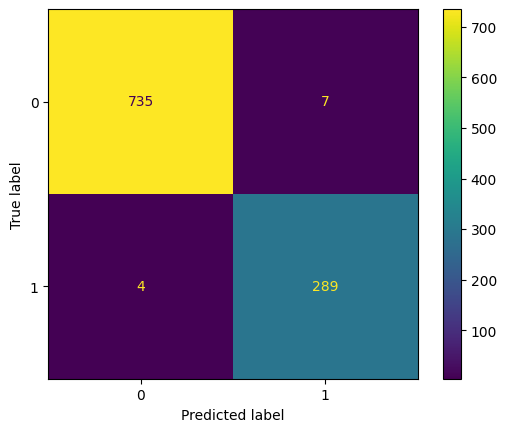

In [40]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Create a ConfusionMatrixDisplay instance
cmd = ConfusionMatrixDisplay(cm, display_labels=decision_tree_model.classes_)

# Plot the confusion matrix
cmd.plot()


In [41]:
import math
from sklearn.metrics import r2_score, mean_squared_error,mean_absolute_percentage_error

maxY=max(y_test)
minY=min(y_test)
a=maxY-minY
print ("The R-Squared value is: "+str(r2_score(y_test, y_pred)))
print ("The Mean Squared Error value is: "+str(mean_squared_error(y_test, y_pred)))
print ("The Root Mean Squared Error value is: "+str(math.sqrt(mean_squared_error(y_test, y_pred))))
print ("The Normalize Root Mean Squared Error value is: "+str(math.sqrt(mean_squared_error(y_test, y_pred))/a*100))
print ("The Mean Absolute Error value is: "+str(mean_absolute_percentage_error(y_test, y_pred)*100))

The R-Squared value is: 0.9476325400402933
The Mean Squared Error value is: 0.010628019323671498
The Root Mean Squared Error value is: 0.1030922854711811
The Normalize Root Mean Squared Error value is: 10.30922854711811
The Mean Absolute Error value is: 3045912791458306.5


### Dumpt the model to a external file

In [42]:
import pickle

with open('decision_tree_model.pkl', 'wb') as file:
    pickle.dump(decision_tree_model, file)

# Modified Naïve Bayes

In [46]:
Email_dataset.head()

,Email_text,Email_Subject,Labels
0,subject enron methanol meter 988291\r\nthis...,enron methanol meter 988291,0
1,subject hpl nom for january 9 2001\r\n see at...,hpl nom for january 9 2001,0
2,subject neon retreat\r\nho ho ho we re aroun...,neon retreat,0
3,subject photoshop windows office cheap mai...,photoshop windows office cheap main trending,1
4,subject re indian springs\r\nthis deal is to ...,re indian springs,0


In [49]:
total_emails = len(Email_dataset)

#prior probabilities
spam_not_spam_counter = Counter(Email_dataset["Labels"])
prior_not_spam = spam_not_spam_counter[0] / total_emails
prior_spam = spam_not_spam_counter[1] / total_emails
print(prior_not_spam)
print(prior_spam)

0.7101140978534133
0.2898859021465867


In [50]:
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords

stop_words = set(stopwords.words('english'))
for word in stop_words:
    word = remove_punctuations(word)
# stop_words = {word.translate(str.maketrans('', '', string.punctuation)) for word in stop_words}
custom_stop_words = {
    "gave",
    "see",
    "etc"
}

stop_words.update(custom_stop_words)
# print(stop_words)

# def remove_words(text, words):
#     for word in words:
#         text = text.replace(word, '')
#     return text

# def remove_nums(text):
#     text = ''.join([i for i in text if not i.isdigit()])
#     return text

# non_spam_body = Non_Spam["Email_text"].apply(lambda x: remove_words(x, stop_words)).apply(lambda x: remove_nums(x))
# spam_body = Spam["Email_text"].apply(lambda x: remove_words(x, stop_words)).apply(lambda x: remove_nums(x))

def remove_stopwords(body):
    return ' '.join([word for word in body.split() if word not in stop_words and not word.isdigit() and not re.match(r'(\w)\1{1,}', word) and not len(word) <= 2])

def remove_single_words(set, set2):
    text = ' '.join(set2)
    text = text.split()
    word_counts = Counter(text)
    single_occurrence_words = {text for text, count in word_counts.items() if count <= 35}
    return [' '.join(filter(lambda text: text not in single_occurrence_words, set.split())) for set in set]

def count_and_combine(set):
    return dict(Counter("".join(set).split()))


def smoothing(set1, set2, smoothing:int, reg:int):
    first_set = set("".join(set1).split())
    second_set = set("".join(set2).split())
    first_dict = count_and_combine(set1)
    second_dict = count_and_combine(set2)
    for word in first_dict:
        first_dict[word] += smoothing
    
    for word in second_dict:
        second_dict[word] += smoothing
    
    if first_set != second_set:
        for word in first_set:
            if word not in second_set:
                second_dict[word] = 1
        
        for word in second_set:
            if word not in first_set:
                first_dict[word] = 1
    
    temp_first_dict = first_dict.copy()
    for word in temp_first_dict:
        if first_dict[word] < reg and second_dict[word] < reg:
            del first_dict[word]
            del second_dict[word]

    temp_second_dict = second_dict.copy()
    for word in temp_second_dict:
        if second_dict[word] < reg and first_dict[word] < reg:
            del first_dict[word]
            del second_dict[word]
    return [first_dict, second_dict]

def calc_prob(set):
    set_len = len(set)
    set_total = 0

    for word in set:
        set_total += set[word]
    
    prob = set
    for word in set:
        prob[word] = set[word] / set_total
    
    return prob


# Remove stopwords from each paragraph in the list
first_non_spam_body = [remove_stopwords(body) for body in Non_Spam["Email_text"]]
first_spam_body = [remove_stopwords(body) for body in Spam["Email_text"]]
# print(first_non_spam_body)

smoothing_list = smoothing(first_non_spam_body, first_spam_body, 1, 20)
first_non_spam_body = smoothing_list[0]
first_spam_body = smoothing_list[1]

non_spam_prob = calc_prob(first_non_spam_body)
spam_prob = calc_prob(first_spam_body)
for word in spam_prob:
    print('"' + word + '": ' + str(spam_prob[word]) + ',')

# print(first_non_spam_body)
# print(non_spam_prob_len)
# print(first_spam_body)
# print(spam_prob_len)

# total_spam_body = non_spam_body + spam_body
# non_spam_body = remove_single_words(non_spam_body, total_spam_body)
# spam_body = remove_single_words(spam_body, total_spam_body)




# print(Spam["Email_text"])
# print(set(spam_body))


# vectorizer = CountVectorizer()
# #vectorizer.fit(X_train)
# non_spam_words = vectorizer.fit_transform(non_spam_body)
# non_spam_word_list = vectorizer.get_feature_names_out()
# non_spam_word_count_list = [0 for e in non_spam_word_list]
# non_spam_count_total = 0

# for line in non_spam_words.toarray():
#     i = 0
#     for count in line:
#         non_spam_word_count_list[i] += count
#         non_spam_count_total += count
#         i += 1
# non_spam_word_count_dict = dict(zip(non_spam_word_list, non_spam_word_count_list))

# # temp_non_spam_word_count_list = non_spam_word_count_list
# # for word in temp_non_spam_word_count_list:
# #     if non_spam_word_count_list[word] == 1:
# #         del non_spam_word_count_list[word]
# non_spam_prob = non_spam_word_count_dict
# print(non_spam_prob)

# for word in non_spam_word_list:
#     non_spam_prob[word] = non_spam_word_count_dict[word] / non_spam_count_total
# print(non_spam_prob)


# vectorizer2 = CountVectorizer()
# #vectorizer.fit(X_train)
# spam_words = vectorizer2.fit_transform(spam_body)
# spam_word_list = vectorizer2.get_feature_names_out()
# # print(set(spam_word_list))
# spam_word_count_list = [0 for e in spam_word_list]
# spam_count_total = 0

# for line in spam_words.toarray():
#     i = 0
#     for count in line:
#         spam_word_count_list[i] += count
#         spam_count_total += count
#         i += 1
# spam_word_count_dict = dict(zip(spam_word_list, spam_word_count_list))

# # temp_spam_word_count_list = spam_word_count_list
# # for word in temp_spam_word_count_list:
# #     if spam_word_count_dict[word] == 1:
# #         del spam_word_count_dict[word]
# spam_prob = spam_word_count_dict
# print(spam_prob)

# for word in spam_word_list:
#     spam_prob[word] = spam_word_count_dict[word] / spam_count_total
# print(spam_prob)

"photoshop": 0.0008488341629552005,
"windows": 0.0021797222949960704,
"office": 0.0019072570081215615,
"cheap": 0.0008278752947340844,
"main": 0.0001781503798794865,
"managing": 8.383547288446424e-05,
"pure": 5.239717055279015e-05,
"looking": 0.0026722556981922975,
"medication": 0.00036678019386953103,
"best": 0.0026722556981922975,
"source": 0.0007545192559601781,
"make": 0.0020330102174482578,
"material": 0.0009326696358396647,
"better": 0.0009221902017291067,
"law": 0.00022006811632171864,
"easy": 0.001037463976945245,
"enough": 0.00036678019386953103,
"bad": 0.0003982184962012051,
"found": 0.0005239717055279015,
"site": 0.0017081477600209588,
"net": 0.0020644485197799317,
"delivery": 0.0005030128373067855,
"private": 0.0009117107676185486,
"secure": 0.0006811632171862719,
"week": 0.0009850668063924547,
"million": 0.002095886822111606,
"got": 0.000702122085407388,
"anything": 0.00026198585276395077,
"ever": 0.0008173958606235263,
"want": 0.0022111605973277443,
"erection": 0.00025150

In [51]:
# spam_example = """Subject: Urgent Opportunity for Massive Profits!
# Dear [Recipient],
# Are you tired of struggling to make ends meet? Are you ready to unlock the secret to financial freedom? Look no further! Our revolutionary system guarantees massive profits with minimal effort.
# With our proven method, you can start earning thousands of dollars from the comfort of your own home. No experience required! Simply follow our step-by-step guide, and watch your bank account grow.
# But act fast! This exclusive opportunity won't last long. Join the ranks of our satisfied customers who are already living the life they've always dreamed of.
# Click the link below to get started today!
# [Link to dubious website]
# Don't miss out on this life-changing opportunity!
# Best regards,
# [Spam Sender]
# P.S. Still not convinced? Check out these testimonials from our happy customers!"""
# spam_example = """Summer Classes Still Available
# Summer Session 2024 starts soon, but there’s still time to register! Enroll early to guarantee your seat in the class.

# With 800+ class sections to choose from, Summer Session 2024 is a great way to:

# Raise your GPA.
# Take the classes you couldn’t get into in fall or spring.
# Reach the 30 units per year you need to graduate on time.
# With the majority of classes being online or hybrid, Summer Session will add flexibility to your schedule.

# To register for Summer Session 2024:
# Click the button below to go to your Student Portal.
# Click Student Homepage.
# Click Manage Classes tile.
# Click on Class Search and Enroll.
# Add classes to your cart the same way you would for fall or spring (make sure you set the Course Career to Extended Education).
# Register Now
# Note: Disney Aspire does not cover summer tuition.

# If you have any questions, please contact the TITAN Helpline at (657) 278-7601 or email the CSUF Registration Office at arsc@fullerton.edu.
# facebook	 	Instagram	 	twitter	 	 	Linkedin	 	Forward to Friend
# You received this email because you signed up to receive updates
# from CSUF Extension & International Programs. We respect your privacy.
# You can update your preferences or unsubscribe.
# CSUF Extension & International Programs
# 1111 N. State College Blvd., Fullerton, CA, 92831
# Need to mail us something? Please use the following address when sending postal mail:
# 800 N. State College Blvd., #THall 1403, Fullerton, CA, 92831

# © California State University, Fullerton, All rights reserved.
# """

# spam_example = """Identity Verification Complete
# Your identity verification was successful.

# Log In
# Why did this happen?
# Getting started with Netlify is quick, but this also means that bad actors try to abuse our service to host illegal content, phishing sites, spam, or similar content against our terms of service.

# To protect against this and help make the web safe for everyone, our automated fraud detection system will compare any new sign up against the patterns of fraudulent users, and if there is a high enough correlation, we will trigger this identity verification process.

# Verifying your identity only takes a moment and allows you access to Netlify’s services.

# Thank you for your understanding and cooperation."""
spam_example = """
subject: [CPSC 490.01] Important Notice: No Class and Final Proposal Due on upcoming Tuesday (May 7)

CSUF external service. Use caution and confirm sender.

Dear everyone,

I would like to inform you that there will be no class on the upcoming Tuesday, May 7. Instead, your only remaining task for this course is to submit your group Final Proposal by midnight on May 7 via Canvas.

Additionally, please note that there will be no final exam for this course. You can focus your efforts on preparing for your other classes during the final exam week.

Thank you for your dedication throughout the semester. If you have any questions or need further clarification, please do not hesitate to reach out.


Best regards,

Rong Jin"""
spam_example = spam_example.lower()
spam_example = re.sub(r'[^\w\s]', '', spam_example).split()

total_spam_prob = prior_spam
for word in spam_example:
    if word in spam_prob:
        print(word + " " + str(total_spam_prob) + " * " + str(spam_prob[word]) + " = " + str(total_spam_prob * spam_prob[word]))
        total_spam_prob = total_spam_prob * spam_prob[word]


total_non_spam_prob = prior_not_spam
print(total_non_spam_prob)
for word in spam_example:
    if word in non_spam_prob:
        print(word + " " + str(total_non_spam_prob) + " * " + str(non_spam_prob[word]) + " = " + str(total_non_spam_prob * non_spam_prob[word]))
        total_non_spam_prob = total_non_spam_prob * non_spam_prob[word]


print(total_spam_prob)
print(total_non_spam_prob)

if total_spam_prob >= total_non_spam_prob:
    print("Spam")
else:
    print("Not Spam")

subject 0.2898859021465867 * 0.0016452711553576107 = 0.000476940913146598
important 0.000476940913146598 * 0.0006078071784123657 = 2.8988811068905096e-07
notice 2.8988811068905096e-07 * 0.0009431490699502227 = 2.734077019860056e-10
class 2.734077019860056e-10 * 0.00026198585276395077 = 7.16289499570358e-14
final 7.16289499570358e-14 * 0.00025150641865339274 = 1.8015140675597163e-17
due 1.8015140675597163e-17 * 0.0011946554886036154 = 2.1521886686068397e-20
tuesday 2.1521886686068397e-20 * 0.00019910924810060256 = 4.285206675769447e-24
may 4.285206675769447e-24 * 0.004390882892323814 = 1.8815840682707868e-26
external 1.8815840682707868e-26 * 0.00025150641865339274 = 4.732304704060664e-30
service 4.732304704060664e-30 * 0.0017081477600209588 = 8.08347567997787e-33
use 8.08347567997787e-33 * 0.0022216400314383025 = 1.7958573163796786e-35
confirm 1.7958573163796786e-35 * 0.00042965679853287925 = 7.716023051775408e-39
sender 7.716023051775408e-39 * 2.095886822111606e-05 = 1.6171911033325455

In [52]:
# from sklearn.naive_bayes import BernoulliNB
# from sklearn.metrics import confusion_matrix, accuracy_score

# bnb = BernoulliNB()

# bnb.fit(X_train, y_train)
# y_pred_class = bnb.predict(X_test)
# y_pred_probability = bnb.predict_proba(X_test)
# # metrics.accurarcy_socre(y_test, y_pred_class)

# cm = confusion_matrix(y_test,y_pred_class)
# print(cm)
# print(accuracy_score(y_test, y_pred_class))

# training Multinomial Naive Bayes

In [53]:
from sklearn.naive_bayes import MultinomialNB

bayes_model = MultinomialNB()
bayes_model.fit(X_train_features, y_train)


MultinomialNB()

### Checking accuaracy on training set

In [54]:
y_pred = bayes_model.predict(X_train_features)
cm = confusion_matrix(y_train, y_pred)
print(cm)
accuracy_score(y_train, y_pred)

[[2927    3]
 [ 127 1079]]


0.968568665377176

### Confusiong matrix for training set

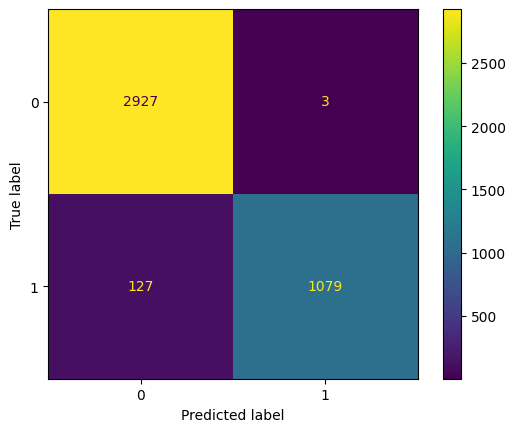

In [55]:
# Compute confusion matrix
cm = confusion_matrix(y_train, y_pred)

# Create a ConfusionMatrixDisplay instance
cmd = ConfusionMatrixDisplay(cm, display_labels=bayes_model.classes_)

# Plot the confusion matrix
cmd.plot()


### Checking Accuracy on testing set 

In [56]:
y_pred = bayes_model.predict(X_test_features)
cm = confusion_matrix(y_test, y_pred)
print(cm)
accuracy_score(y_test, y_pred)

[[741   1]
 [ 79 214]]


0.9227053140096618

### Confusion Matrix for test set

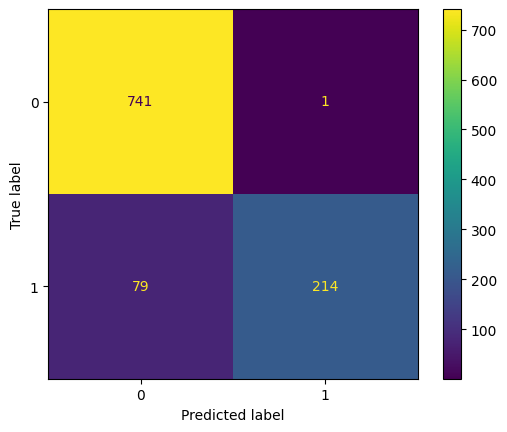

In [57]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Create a ConfusionMatrixDisplay instance
cmd = ConfusionMatrixDisplay(cm, display_labels=decision_tree_model.classes_)

# Plot the confusion matrix
cmd.plot()


In [58]:
import math
from sklearn.metrics import r2_score, mean_squared_error,mean_absolute_percentage_error

maxY=max(y_test)
minY=min(y_test)
a=maxY-minY
print ("The R-Squared value is: "+str(r2_score(y_test, y_pred)))
print ("The Mean Squared Error value is: "+str(mean_squared_error(y_test, y_pred)))
print ("The Root Mean Squared Error value is: "+str(math.sqrt(mean_squared_error(y_test, y_pred))))
print ("The Normalize Root Mean Squared Error value is: "+str(math.sqrt(mean_squared_error(y_test, y_pred))/a*100))
print ("The Mean Absolute Error value is: "+str(mean_absolute_percentage_error(y_test, y_pred)*100))

The R-Squared value is: 0.6191457457475876
The Mean Squared Error value is: 0.07729468599033816
The Root Mean Squared Error value is: 0.27801921874276636
The Normalize Root Mean Squared Error value is: 27.801921874276637
The Mean Absolute Error value is: 435130398779765.75


### Dump the model to a external file

In [59]:
with open('bayes_model.pkl', 'wb') as file:
    pickle.dump(bayes_model, file)

### Making Support Vector

In [60]:
from sklearn.svm import SVC
support_vecotr_model = SVC(kernel='rbf', random_state=42)
support_vecotr_model.fit(X_train_features, y_train)


SVC(random_state=42)

### Checking accuaracy on training set

In [61]:
y_pred = support_vecotr_model.predict(X_train_features)
cm = confusion_matrix(y_train, y_pred)
print(cm)
accuracy_score(y_train, y_pred)

[[2930    0]
 [   0 1206]]


1.0

### Confusiong matrix for training set

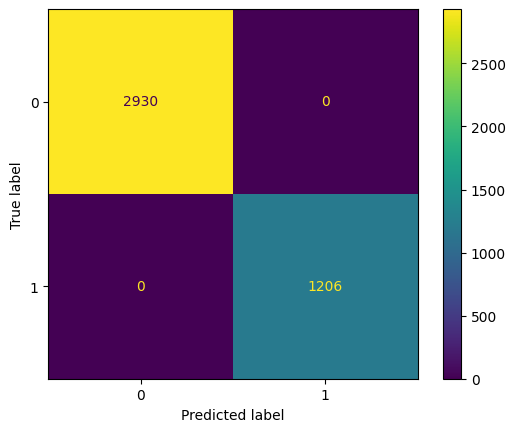

In [62]:
# Compute confusion matrix
cm = confusion_matrix(y_train, y_pred)

# Create a ConfusionMatrixDisplay instance
cmd = ConfusionMatrixDisplay(cm, display_labels=support_vecotr_model.classes_)

# Plot the confusion matrix
cmd.plot()


### Checking Accuracy on testing set 

In [81]:
y_pred = support_vecotr_model.predict(X_test_features)
cm = confusion_matrix(y_test, y_pred)
print(cm)
print(accuracy_score(y_test, y_pred))

[[735   7]
 [  2 291]]
0.991304347826087


### Confusion Matrix for test set

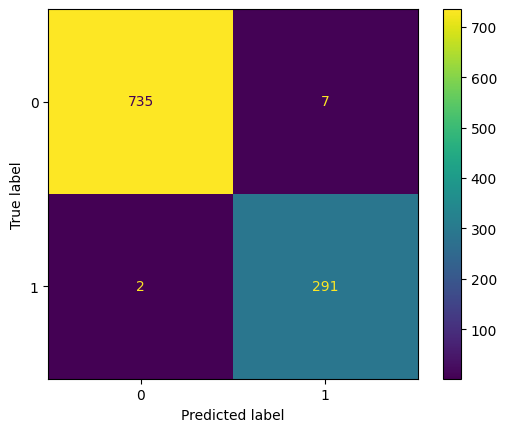

In [64]:
# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Create a ConfusionMatrixDisplay instance
cmd = ConfusionMatrixDisplay(cm, display_labels=support_vecotr_model.classes_)

# Plot the confusion matrix
cmd.plot()


In [65]:
import math
from sklearn.metrics import r2_score, mean_squared_error,mean_absolute_percentage_error

maxY=max(y_test)
minY=min(y_test)
a=maxY-minY
print ("The R-Squared value is: "+str(r2_score(y_test, y_pred)))
print ("The Mean Squared Error value is: "+str(mean_squared_error(y_test, y_pred)))
print ("The Root Mean Squared Error value is: "+str(math.sqrt(mean_squared_error(y_test, y_pred))))
print ("The Normalize Root Mean Squared Error value is: "+str(math.sqrt(mean_squared_error(y_test, y_pred))/a*100))
print ("The Mean Absolute Error value is: "+str(mean_absolute_percentage_error(y_test, y_pred)*100))

The R-Squared value is: 0.9571538963966036
The Mean Squared Error value is: 0.008695652173913044
The Root Mean Squared Error value is: 0.09325048082403138
The Normalize Root Mean Squared Error value is: 9.325048082403137
The Mean Absolute Error value is: 3045912791458306.5


### Dumpt the model to a external file

In [66]:
import pickle

with open('support_vecotr_model.pkl', 'wb') as file:
    pickle.dump(support_vecotr_model, file)

# KNN


In [67]:
from sklearn.neighbors import KNeighborsClassifier
k = 5
knn_model = KNeighborsClassifier(n_neighbors=k)
knn_model.fit(X_train_features, y_train)

KNeighborsClassifier()

### Checking accuaracy on training set

In [68]:
y_pred = knn_model.predict(X_train_features)
cm = confusion_matrix(y_train, y_pred)
print(cm)
accuracy_score(y_train, y_pred)

[[2908   22]
 [  97 1109]]


0.9712282398452611

### Confusiong matrix for training set

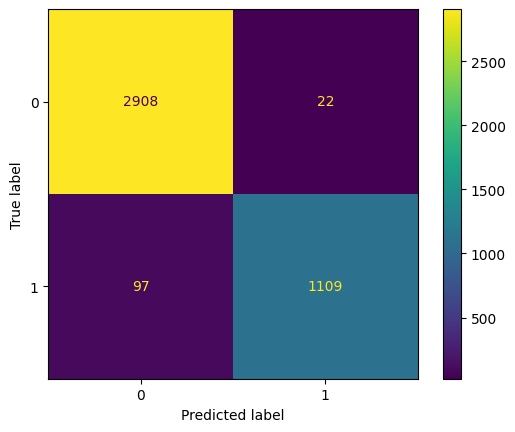

In [69]:
# Compute confusion matrix
cm = confusion_matrix(y_train, y_pred)

# Create a ConfusionMatrixDisplay instance
cmd = ConfusionMatrixDisplay(cm, display_labels=knn_model.classes_)

# Plot the confusion matrix
cmd.plot()


### Checking Accuracy on testing set 

In [70]:
y_pred = knn_model.predict(X_test_features)
cm = confusion_matrix(y_test, y_pred)
print(cm)
accuracy_score(y_test, y_pred)

[[735   7]
 [ 34 259]]


0.9603864734299516

### Confusion Matrix for test set

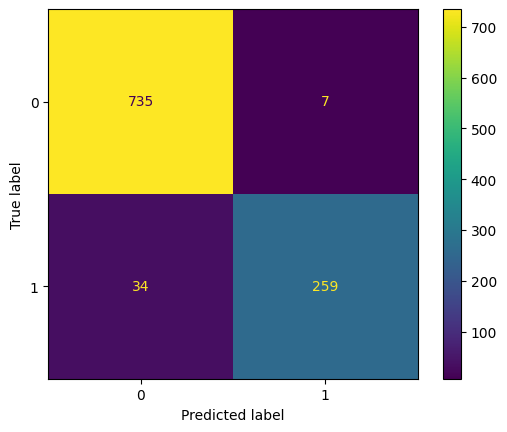

In [71]:
# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Create a ConfusionMatrixDisplay instance
cmd = ConfusionMatrixDisplay(cm, display_labels=knn_model.classes_)

# Plot the confusion matrix
cmd.plot()


In [72]:
import math
from sklearn.metrics import r2_score, mean_squared_error,mean_absolute_percentage_error

maxY=max(y_test)
minY=min(y_test)
a=maxY-minY
print ("The R-Squared value is: "+str(r2_score(y_test, y_pred)))
print ("The Mean Squared Error value is: "+str(mean_squared_error(y_test, y_pred)))
print ("The Root Mean Squared Error value is: "+str(math.sqrt(mean_squared_error(y_test, y_pred))))
print ("The Normalize Root Mean Squared Error value is: "+str(math.sqrt(mean_squared_error(y_test, y_pred))/a*100))
print ("The Mean Absolute Error value is: "+str(mean_absolute_percentage_error(y_test, y_pred)*100))

The R-Squared value is: 0.8048121946956387
The Mean Squared Error value is: 0.03961352657004831
The Root Mean Squared Error value is: 0.1990314713055408
The Normalize Root Mean Squared Error value is: 19.903147130554082
The Mean Absolute Error value is: 3045912791458309.5


### Dumpt the model to a external file

In [73]:
import pickle

with open('knn_model.pkl', 'wb') as file:
    pickle.dump(knn_model, file)

# Random Forest

In [74]:
from sklearn.ensemble import RandomForestClassifier as RFR

random_forest_model = RFR(n_estimators=100, random_state=42)
random_forest_model.fit(X_train_features, y_train)

RandomForestClassifier(random_state=42)

### Checking accuaracy on training set

In [75]:
y_pred = random_forest_model.predict(X_train_features)
cm = confusion_matrix(y_train, y_pred)
print(cm)
accuracy_score(y_train, y_pred)

[[2930    0]
 [   0 1206]]


1.0

### Confusiong matrix for training set

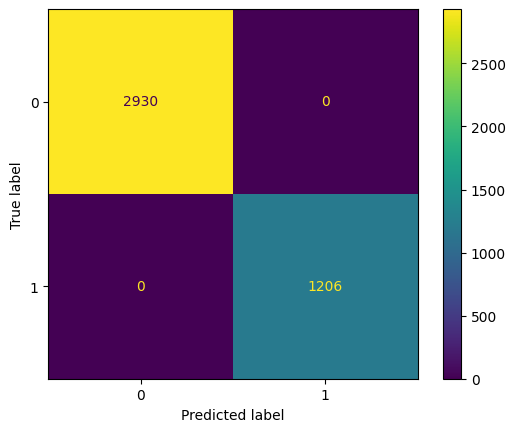

In [76]:
# Compute confusion matrix
cm = confusion_matrix(y_train, y_pred)

# Create a ConfusionMatrixDisplay instance
cmd = ConfusionMatrixDisplay(cm, display_labels=random_forest_model.classes_)

# Plot the confusion matrix
cmd.plot()


### Checking Accuracy on testing set 

In [77]:
y_pred = random_forest_model.predict(X_test_features)
cm = confusion_matrix(y_test, y_pred)
print(cm)
accuracy_score(y_test, y_pred)

[[735   7]
 [  4 289]]


0.9893719806763285

### Confusion Matrix for test set

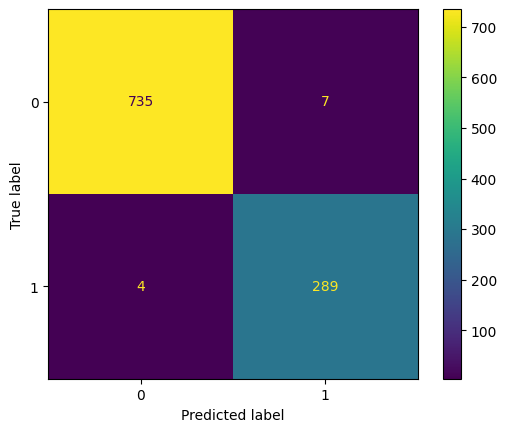

In [78]:
# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Create a ConfusionMatrixDisplay instance
cmd = ConfusionMatrixDisplay(cm, display_labels=random_forest_model.classes_)

# Plot the confusion matrix
cmd.plot()


### Dumpt the model to a external file

In [79]:
import pickle

with open('random_forest_model.pkl', 'wb') as file:
    pickle.dump(random_forest_model, file)

In [80]:
import math
from sklearn.metrics import r2_score, mean_squared_error,mean_absolute_percentage_error

maxY=max(y_test)
minY=min(y_test)
a=maxY-minY
print ("The R-Squared value is: "+str(r2_score(y_test, y_pred)))
print ("The Mean Squared Error value is: "+str(mean_squared_error(y_test, y_pred)))
print ("The Root Mean Squared Error value is: "+str(math.sqrt(mean_squared_error(y_test, y_pred))))
print ("The Normalize Root Mean Squared Error value is: "+str(math.sqrt(mean_squared_error(y_test, y_pred))/a*100))
print ("The Mean Absolute Error value is: "+str(mean_absolute_percentage_error(y_test, y_pred)*100))

The R-Squared value is: 0.9476325400402933
The Mean Squared Error value is: 0.010628019323671498
The Root Mean Squared Error value is: 0.1030922854711811
The Normalize Root Mean Squared Error value is: 10.30922854711811
The Mean Absolute Error value is: 3045912791458307.0
